# Seattle_Housing_Prices_Analysis_and_Prediction

* 2019.05.06 updated 된 자료입니다.
* 집값 예측 및 분석에 대하여 정리한 자료입니다.
* 여러 사이트들을 참조하여 만든 자료로 사이트는 다음과 같습니다.
 
 분석 베이스 : https://www.kaggle.com/yeonmin/default-eda-stacking-introduction
 
 지리 정보 : https://becominghuman.ai/good-feature-building-techniques-tricks-for-kaggle-my-kaggle-code-repository-c953b934f1e6
 
 시간 정보 : https://bigdatascientistblog.wordpress.com/2015/10/07/feature-engineering-with-dates-ii-merging-data-from-public-sources-like-holidays/
 



#### 사용되는 패키지

In [1]:
# 패키지 import
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import time
from datetime import datetime, timedelta,date
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#### 각종 이용되는 함수들 : 아래의 함수들은 위의 '분석 베이스'라는 사이트에서 참조한 자료입니다. (yeonmin님. 감사합니다.)

In [2]:
# train, test를 각 열 별로 concat 하여 합친 뒤, row로 각 value_counts를 나눈 값을 기준으로
# 각 값을 train - test하여 남은 값을 기준으로 train 또는 test로 치우친 정도를 계산함
#   -> 비대칭도와 비슷하다고 볼 수 있음.
def train_test_diff(train_df_, test_df_, cols):
    print('\n')
    print('-------------------------------------------------------------------------------------------------------------------------')
    print(f'{cols} distribution graph')
    print('\n')
    
    result = pd.concat([train_df_[cols].value_counts()/train_df_.shape[0], test_df_[cols].value_counts()/test_df_.shape[0]], axis=1)
    result.columns = ['train_v','test_v']
    result['diff'] = result['train_v'] - result['test_v']
    print(result)
    
    return result

# category 변수에 대하여 price와 train으로 분류한 함수입니다.
def category_dist(train_df_, cols, target_v='price'):
    print('\n')
    print('--------------------------------------------------------------')
    print(f'{cols} distribution')
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    for i in sorted(train_df_[cols].unique()):
        sns.distplot(np.log1p(train_df_.loc[train_df_[cols]==i, target_v]), ax=ax[0])
    ax[0].legend(sorted(train_df_[cols].unique()))
    ax[0].set_title(f'{cols} {target_v} distribution')

    sns.boxplot(x=cols, y=target_v, data=train_df_, ax=ax[1])
    ax[1].set_title(f'{cols} vs {target_v}')
    
    plt.show()

    
    
# category 변수의 train과 test 데이터의 분포 차를 보여주는 함수입니다.
def category_dist_TT(train_df_, test_df_, cols):
    
    
    result = pd.concat([train_df_[cols].value_counts()/train_df_.shape[0], test_df_[cols].value_counts()/test_df_.shape[0]], axis=1)
    result.columns = ['train_df_','test_df_']
    
    result.fillna(0, inplace=True)
    
    plt.figure(figsize=(15,8))
    sns.distplot(result['train_df_'], label='train')
    sns.distplot(result['test_df_'], label='test')
    plt.legend()
    plt.show()
    
    return result
    


# numerical 변수의 train과 test 데이터의 분포 차를 보여주는 함수입니다.
def continous_dist(train_df_, test_df_, cols, target_v='price'):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    sns.distplot(train_df_[cols], ax=ax[0])
    sns.distplot(test_df_[cols], ax=ax[0])
    ax[0].set_title(f'{cols} - train/test distribution')
    
    sns.scatterplot(x=cols, y=target_v, data=train_df_, ax=ax[1])
    ax[1].set_title(f'{cols} - {target_v} scatterplot')
    
    plt.show()



# 격자를 넣어서 scatter를 표현함.
def scatter_quantile_visualize(df_, col1, col2):
    col1_quant = np.arange(0,1.1,0.1)
    col2_quant = np.arange(0,1.1,0.1)

    for quantile_value in df_[col1].quantile(col1_quant):
        plt.axvline(quantile_value, color='red', alpha=0.3)
    for quantile_value in df_[col2].quantile(col2_quant):
        plt.axhline(quantile_value, color='blue', alpha=0.3)
        
    sns.scatterplot(col1, col2, hue='price',data=df_)
    
    plt.title('{} - {}'.format(col1,col2))
    plt.show()


## 분석과정

* 데이터 살펴보기(EDA)

* 데이터 engineering

* 모델링

### 데이터 살펴보기(EDA)
* data load
* train / test data 분포 차이
* target값의 분포
* 시간에 따른 target값의 변화
* 각 변수의 특징

data load

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

print("train.csv. Shape : ",train_df.shape)
print("test.csv. Shape : ",test_df.shape)

train.csv. Shape :  (15035, 21)
test.csv. Shape :  (6468, 20)


#### Train / Test data의 분포 차이 :  '분석 베이스'라는 곳의 사이트에서 참조한 자료입니다.
    
1.Categorical variable : value_counts()를 해서 그 값을 row 값으로 나눈 값을 기준으로 train, test 값을 비교함

* 전체적으로 비슷한 경향을 보임 
 * bedrooms : test의 경우 10까지만 있음 -> train도 10까지만 있는 데이터로 수정.
 * bathrooms : test data는 6.75까지만 있음 -> 7.5까지만 학습함.






-------------------------------------------------------------------------------------------------------------------------
bedrooms distribution graph


     train_v    test_v      diff
0   0.000266  0.001391 -0.001125
1   0.008846  0.009586 -0.000740
2   0.128434  0.126005  0.002429
3   0.454606  0.452845  0.001761
4   0.319056  0.318955  0.000101
5   0.073695  0.074830 -0.001135
6   0.012504  0.012832 -0.000328
7   0.001463  0.002474 -0.001010
8   0.000665  0.000464  0.000201
9   0.000333  0.000155  0.000178
10  0.000133  0.000155 -0.000022
11       NaN  0.000155       NaN
33       NaN  0.000155       NaN


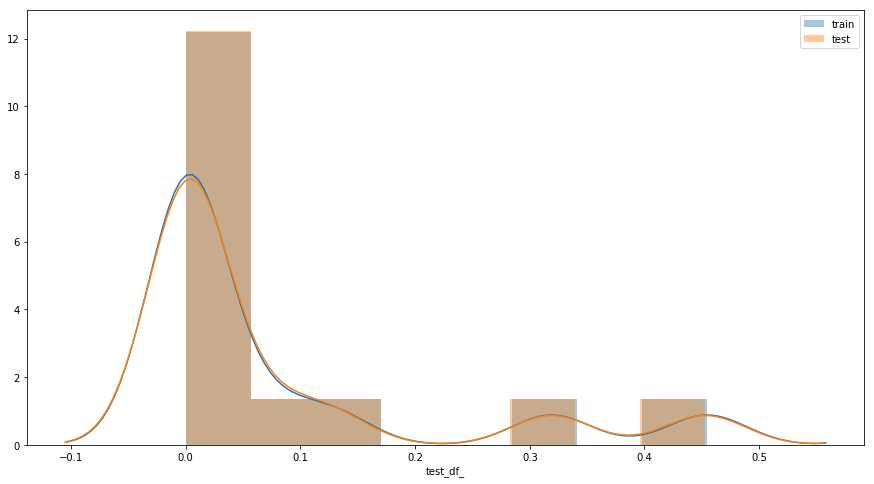



-------------------------------------------------------------------------------------------------------------------------
bathrooms distribution graph


       train_v    test_v      diff
0.00  0.000266  0.000928 -0.000662
0.50  0.000200  0.000155  0.000045
0.75  0.002993  0.004020 -0.001027
1.00  0.177918  0.177025  0.000893
1.25  0.000333  0.000618 -0.000286
1.50  0.067110  0.066327  0.000784
1.75  0.140472  0.141775 -0.001303
2.00  0.090256  0.087199  0.003058
2.25  0.095311  0.092919  0.002392
2.50  0.249285  0.249845 -0.000560
2.75  0.056069  0.052566  0.003503
3.00  0.032790  0.039734 -0.006944
3.25  0.027270  0.027211  0.000059
3.50  0.033921  0.033859  0.000062
3.75  0.007183  0.007267 -0.000083
4.00  0.006651  0.005411  0.001240
4.25  0.003791  0.003401  0.000390
4.50  0.004257  0.005411 -0.001155
4.75  0.001064  0.001082 -0.000018
5.00  0.000931  0.001082 -0.000151
5.25  0.000732  0.000309  0.000422
5.50  0.000466  0.000464  0.000002
5.75  0.000200  0.000155  0.000045
6.00 

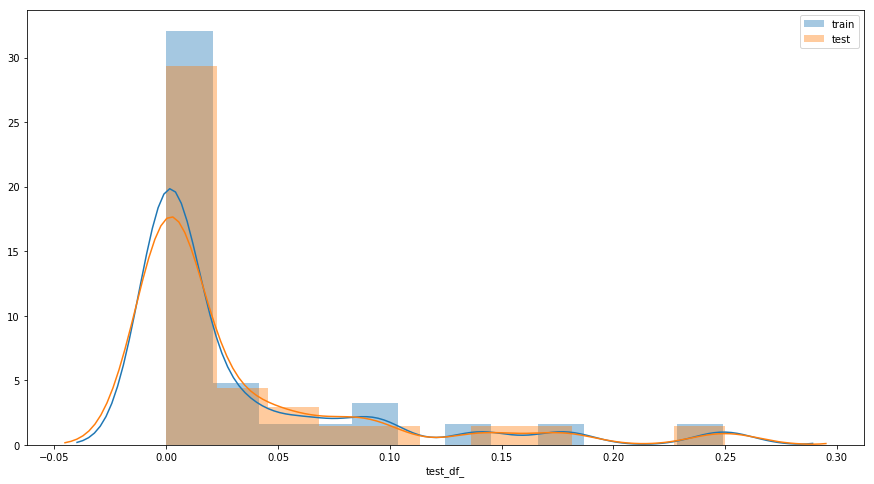



-------------------------------------------------------------------------------------------------------------------------
floors distribution graph


      train_v    test_v      diff
1.0  0.489591  0.502628 -0.013037
2.0  0.386432  0.371985  0.014447
1.5  0.088460  0.087353  0.001107
3.0  0.027735  0.029994 -0.002259
2.5  0.007516  0.007421  0.000095
3.5  0.000266  0.000618 -0.000352


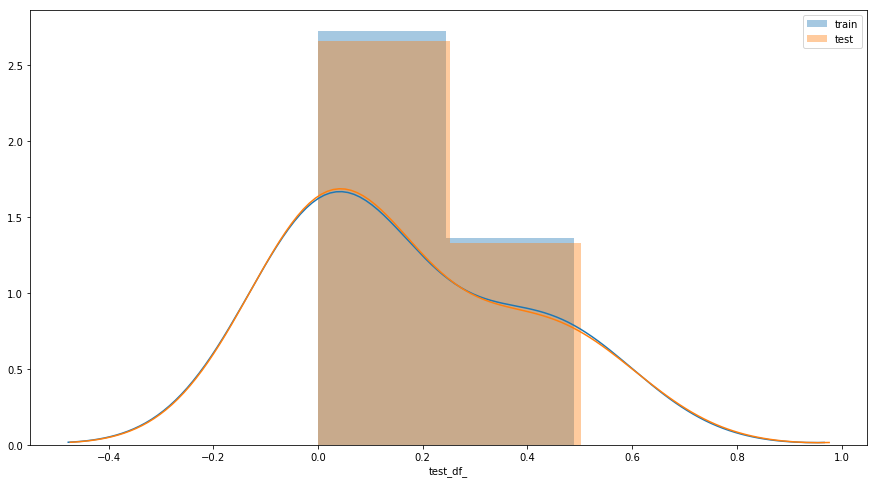



-------------------------------------------------------------------------------------------------------------------------
waterfront distribution graph


    train_v    test_v      diff
0  0.992883  0.991342  0.001541
1  0.007117  0.008658 -0.001541


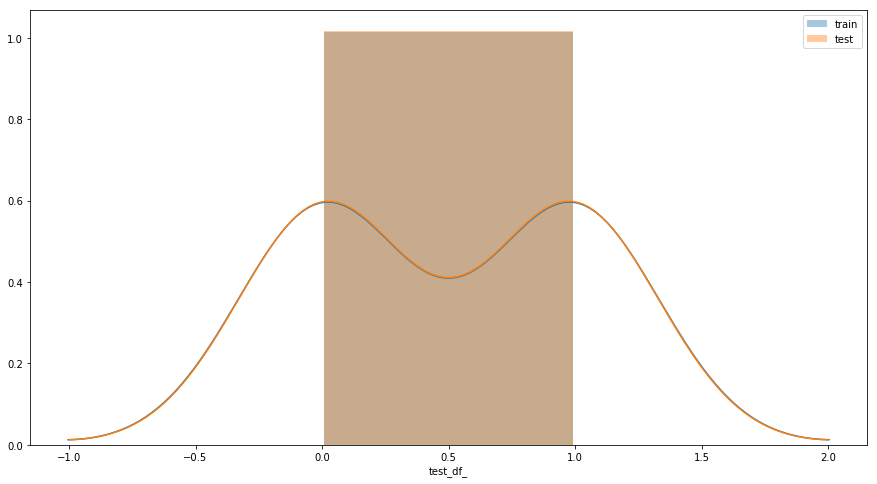



-------------------------------------------------------------------------------------------------------------------------
view distribution graph


    train_v    test_v      diff
0  0.901097  0.902443 -0.001345
1  0.016029  0.014069  0.001960
2  0.044230  0.045918 -0.001688
3  0.024809  0.020717  0.004091
4  0.013834  0.016852 -0.003018


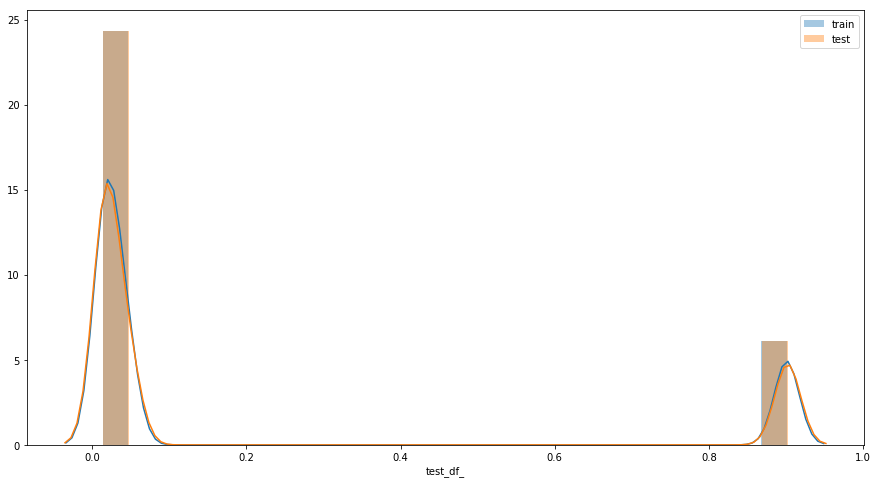



-------------------------------------------------------------------------------------------------------------------------
condition distribution graph


    train_v    test_v      diff
3  0.651347  0.644403  0.006944
4  0.263119  0.262987  0.000132
5  0.076821  0.082560 -0.005740
2  0.007316  0.008813 -0.001496
1  0.001397  0.001237  0.000160


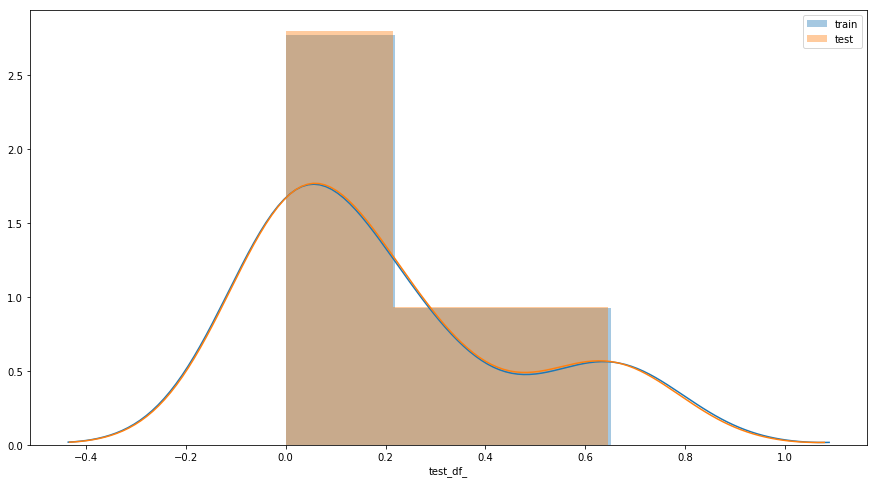



-------------------------------------------------------------------------------------------------------------------------
grade distribution graph


     train_v    test_v      diff
1   0.000067       NaN       NaN
3   0.000133  0.000155 -0.000022
4   0.001530  0.000928  0.000602
5   0.011573  0.009586  0.001987
6   0.093515  0.094465 -0.000950
7   0.414233  0.417594 -0.003361
8   0.279814  0.284941 -0.005127
9   0.123379  0.116574  0.006805
10  0.051945  0.054113 -0.002167
11  0.019155  0.016698  0.002458
12  0.004057  0.004329 -0.000272
13  0.000599  0.000618 -0.000020


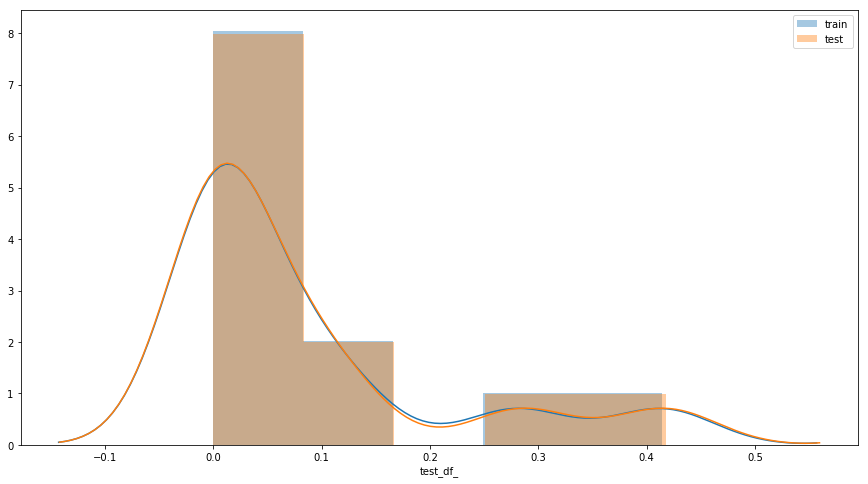



-------------------------------------------------------------------------------------------------------------------------
date distribution graph


                  train_v    test_v      diff
20140502T000000  0.003060  0.003247 -0.000187
20140503T000000  0.000200  0.000155  0.000045
20140504T000000  0.000200  0.000309 -0.000110
20140505T000000  0.004124  0.003401  0.000722
20140506T000000  0.003924  0.003711  0.000214
20140507T000000  0.004390  0.004174  0.000215
20140508T000000  0.003525  0.004329 -0.000804
20140509T000000  0.003991  0.003247  0.000744
20140510T000000  0.000200  0.000309 -0.000110
20140511T000000  0.000133       NaN       NaN
20140512T000000  0.003791  0.003556  0.000235
20140513T000000  0.003525  0.005102 -0.001577
20140514T000000  0.003326  0.004793 -0.001467
20140515T000000  0.003658  0.004174 -0.000516
20140516T000000  0.003525  0.003092  0.000433
20140517T000000  0.000067       NaN       NaN
20140518T000000  0.000200  0.000618 -0.000419
20140519T000000  0.004

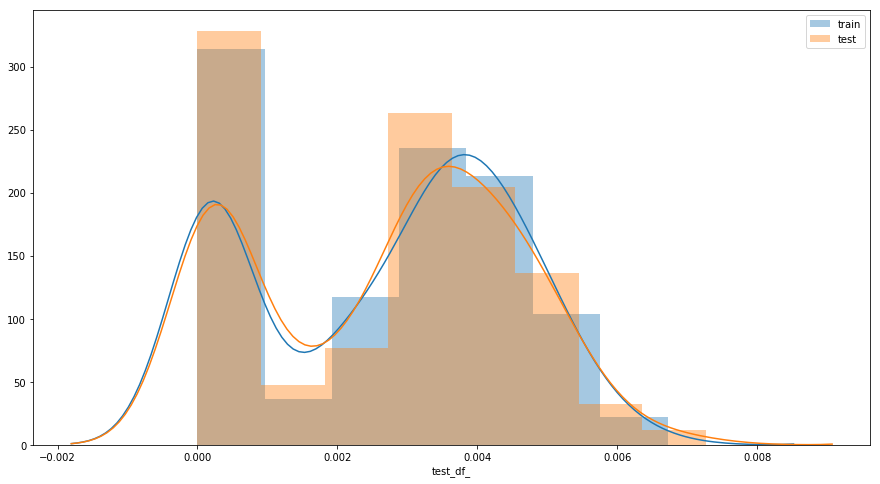

In [4]:
category_col = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade','date']

for i in category_col:
    train_test_diff(train_df, test_df, i)
    category_dist_TT(train_df, test_df, i)

2.Continuity variable
 * sqft_lot, sqft_basement, sqft_lot15는 feature 정규화(log화)가 필요해 보임.
 * sqft_living, sqft_above는 log화 할지 생각해보기.

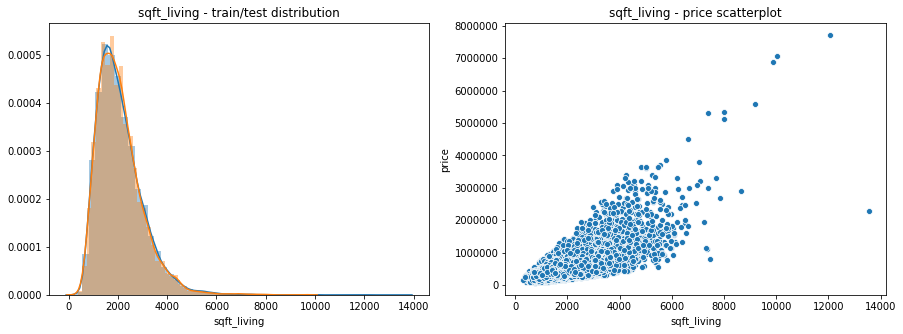

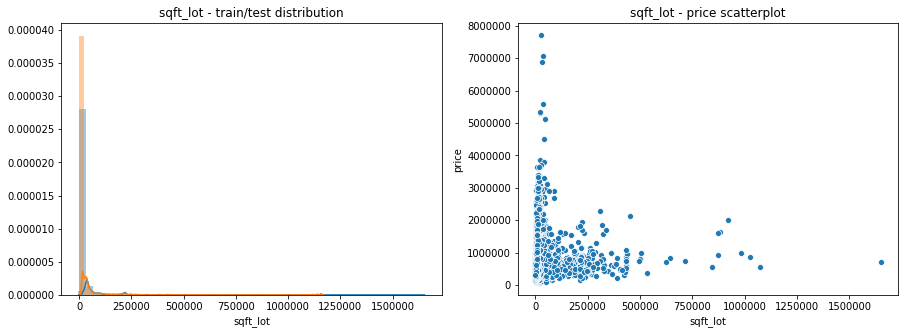

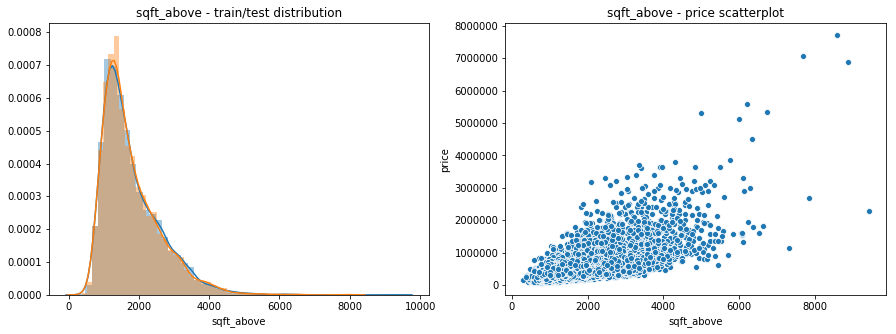

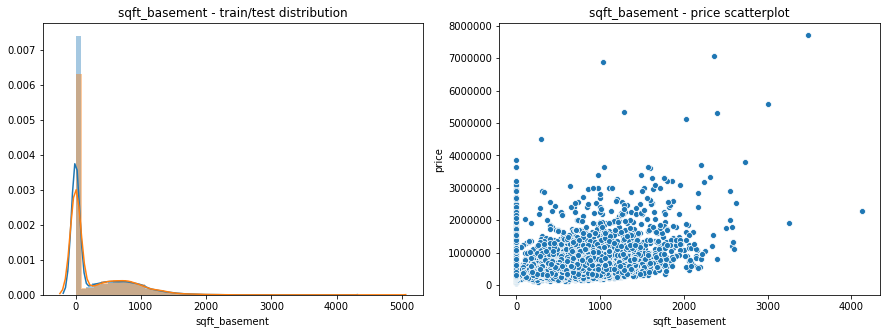

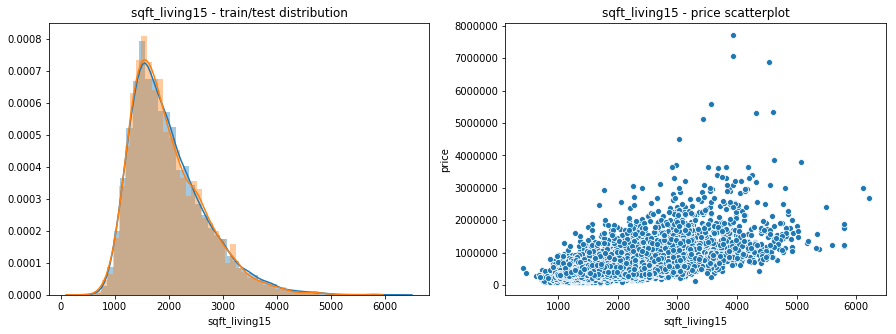

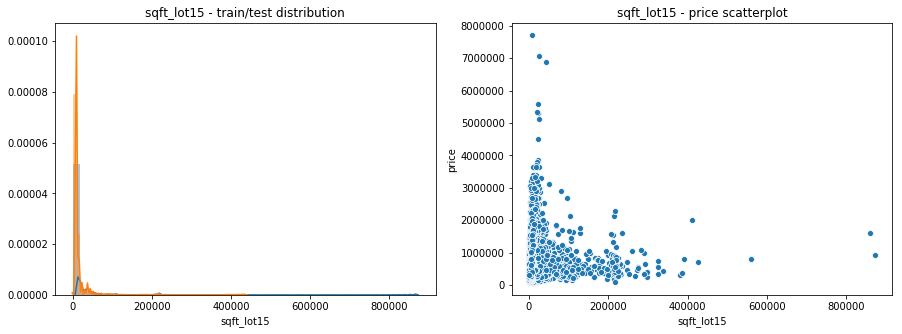

In [5]:
area_feature = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']

for col in area_feature:
    continous_dist(train_df, test_df, col)

#### Target 값의 분포
* 정규분포 형태의 모양과 맞지 않음 : 비대칭도(왜도)가 큰 경우 log를 적용하면 정규분포 모양에 가까워질 수 있음.


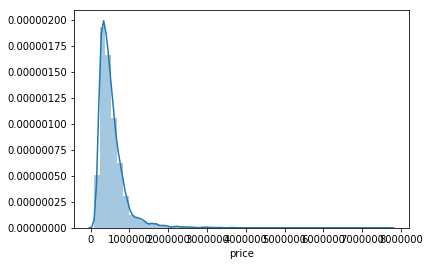

In [6]:
sns.distplot(train_df['price'])

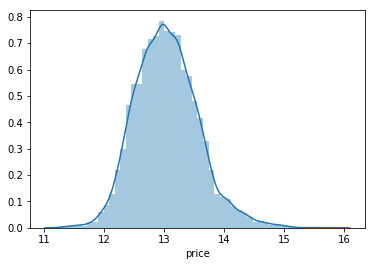

In [7]:
# applied log graph
sns.distplot(np.log1p(train_df['price']))



In [8]:
# log로 바꿈
train_df['price'] = np.log1p(train_df['price'])
train_df['price'].head(3)

0    12.309987
1    12.100718
2    13.142168
Name: price, dtype: float64

#### 시간에 따른 target 값의 변화 : 계절성이 보이진 않음

In [9]:
# 날짜 데이터 datetime 형태로 바꾸기
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

각 날짜의 price 그래프

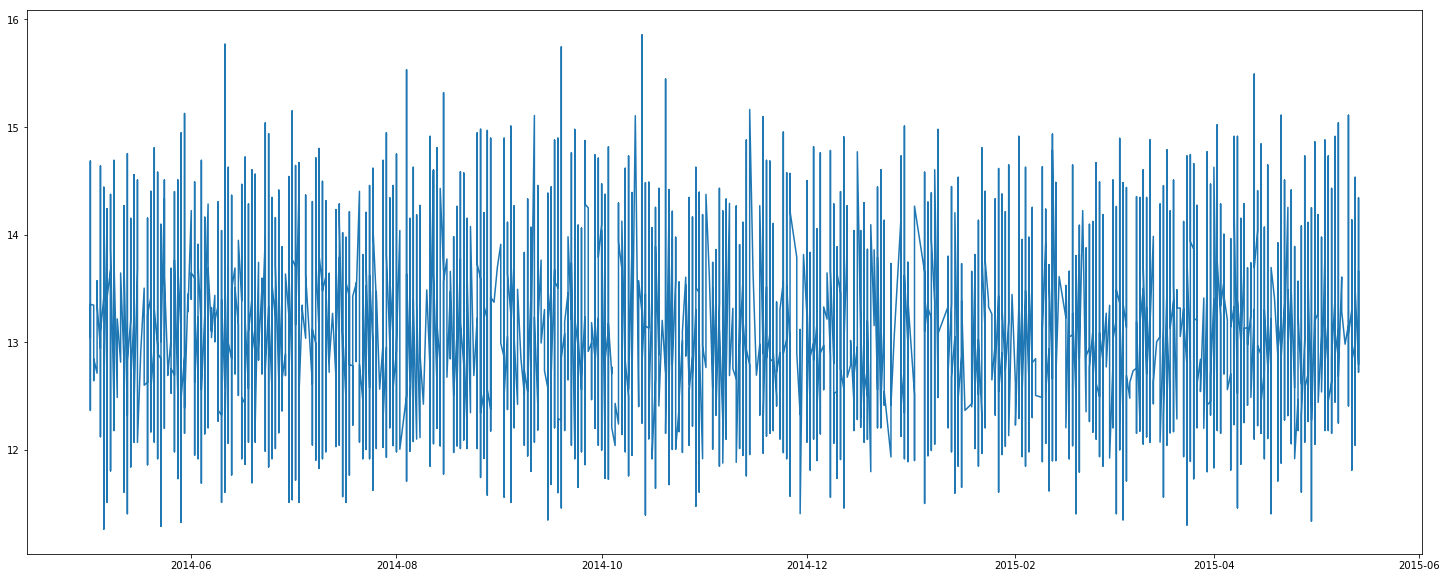

In [10]:
data = train_df[['date','price']].sort_values('date')
data = data.reset_index()

# 1. 전체 : 계절성이 잘 보이진 않음 ->> 좀 더 세부적으로 볾
plt.figure(figsize = (25,10))
plt.plot(data['date'], data['price'])
plt.show()

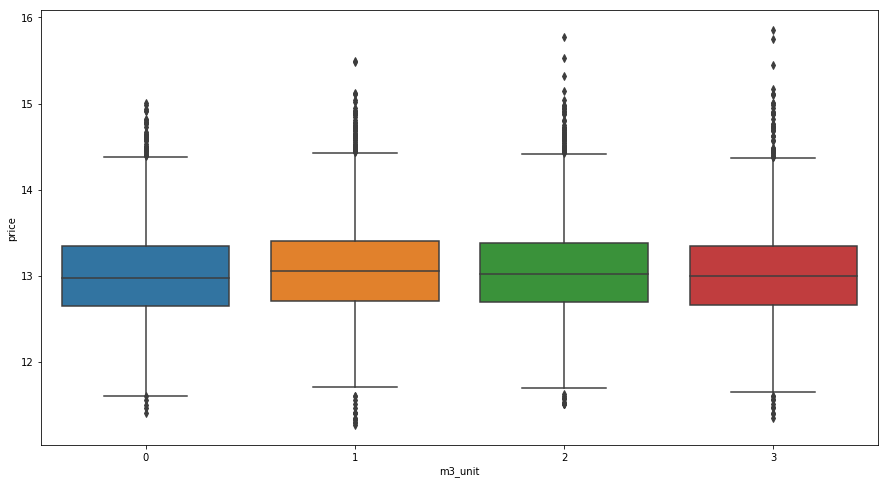

In [11]:
# 1-0. 3개월 단위 boxplot
def m3_apply(x):
    if x.month == 12 or x.month <3:
        return 0
    
    elif x.month < 6:
        return 1
    
    elif x.month < 9:
        return 2
    
    else :
        return 3
    

data['m3_unit'] = data['date'].apply(lambda x : m3_apply(x))
plt.figure(figsize=(15,8))
sns.boxplot(x="m3_unit", y="price", data=data)
plt.show()

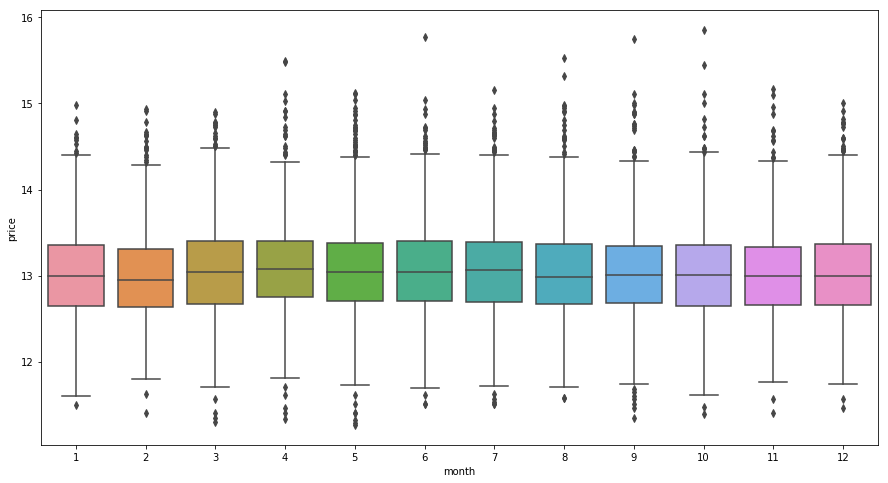

In [12]:
# 1-1. 달 단위 boxplot 그리기 : 1개월 단위로 쪼갬
data['month'] = data['date'].apply(lambda x : x.month)
plt.figure(figsize=(15,8))
sns.boxplot(x="month", y="price", data=data)
plt.show() 

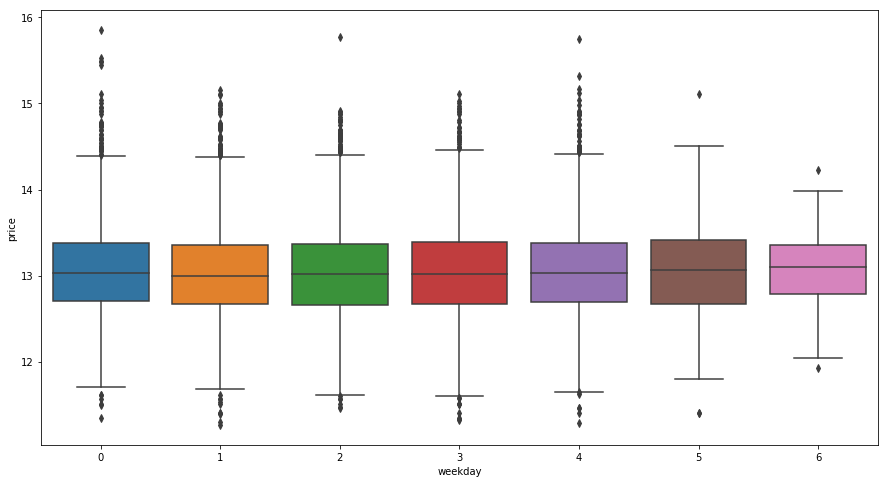

In [13]:
# 1-2. 요일 단위 boxplot 그리기
data['weekday'] = data['date'].apply(lambda x : x.weekday())
plt.figure(figsize=(15,8))
sns.boxplot(x="weekday", y="price", data=data)
plt.show()     

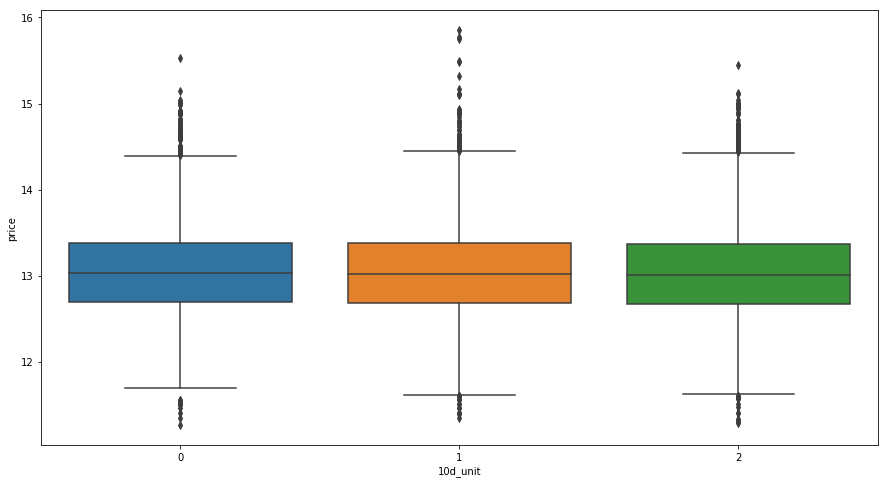

In [14]:
# 1-3. 10일 단위로 끊기
def d10_apply(x):
    
    if x.day < 10:
        return 0
    elif x.day < 20:
        return 1
    else :
        return 2
    
data['10d_unit'] = data['date'].apply(lambda x : d10_apply(x))
plt.figure(figsize=(15,8))
sns.boxplot(x="10d_unit", y="price", data=data)
plt.show()      

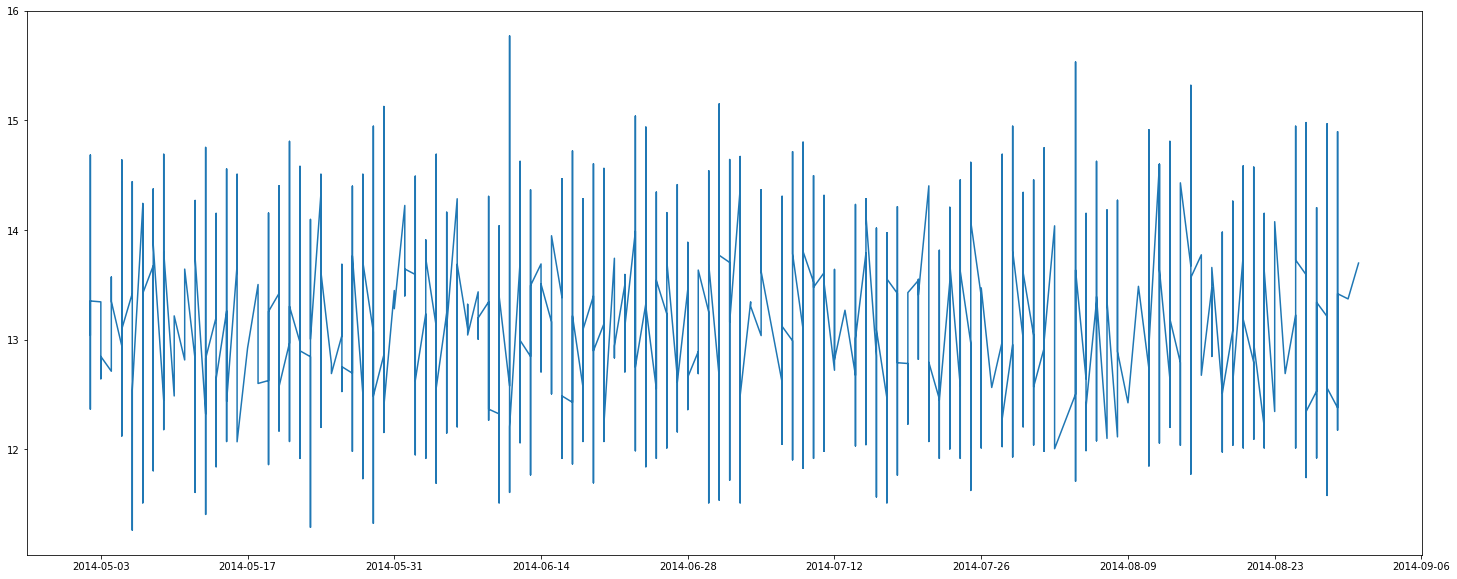

In [15]:
# 2. 3개월만 보기
temp_df = data[(data['date'] >= '2014-05-02') & (data['date'] < '2014-09-01 00:00:00')]
plt.figure(figsize = (25,10))
plt.plot(temp_df['date'], temp_df['price'])
plt.show()

각 날짜별 price의 count, sum, mean, std 보기

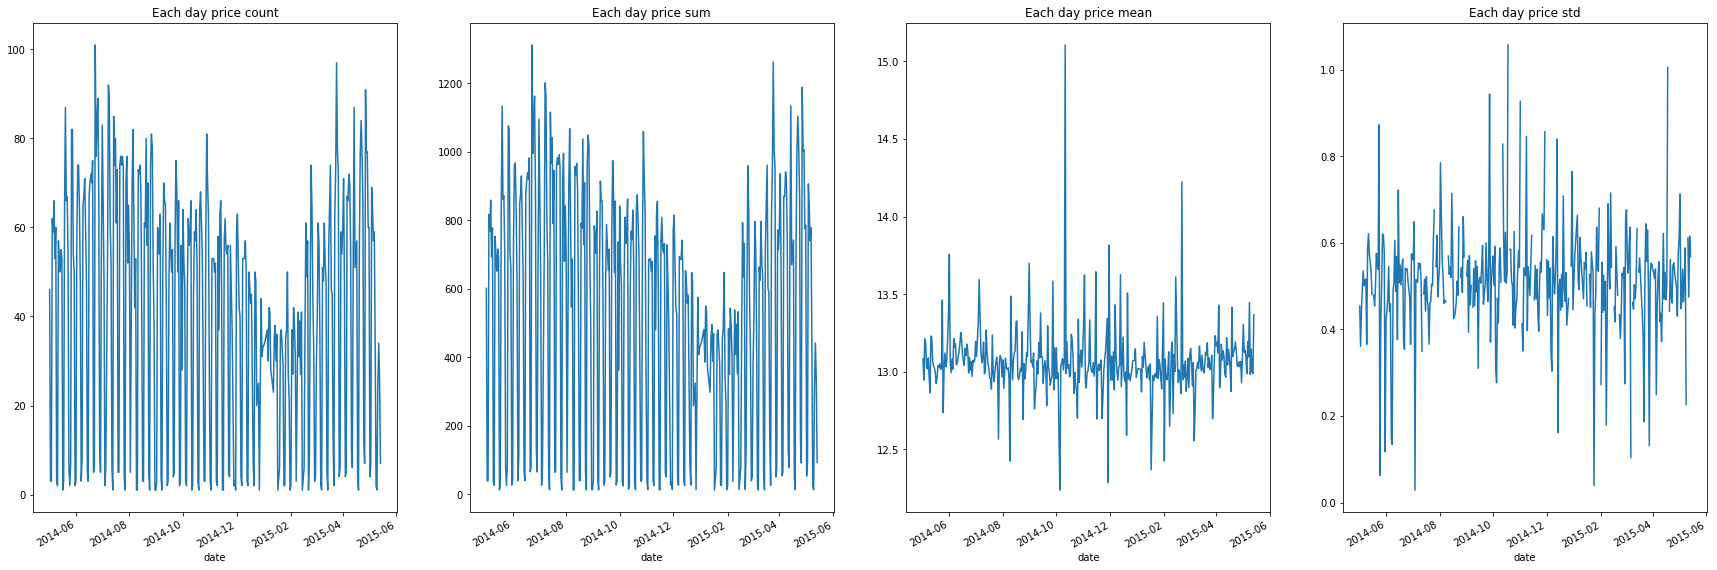

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13311,13311,2014-10-11,15.10612,5,6.0,5490,19897,2.0,0,0,...,12,5490,0,2005,0,98039,47.6165,-122.236,2910,17600


In [16]:
fig, ax = plt.subplots(1, 4, figsize=(30,10))
train_df.groupby('date')['price'].count().plot(ax=ax[0])
ax[0].set_title('Each day price count')
train_df.groupby('date')['price'].sum().plot(ax=ax[1])
ax[1].set_title('Each day price sum')
train_df.groupby('date')['price'].mean().plot(ax=ax[2])
ax[2].set_title('Each day price mean')
train_df.groupby('date')['price'].std().plot(ax=ax[3])
ax[3].set_title('Each day price std')
plt.show()

# 급격히 높아진 price mean 부분 : 제거할지 말지 생각해봄.
train_df.loc[train_df['date']==np.argmax(train_df.groupby('date')['price'].mean())]
